In [2]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
#if i want to speed up and use one file
#files2 = "CSVLog_20190518_122417.csv"

#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set
files = "aggregate_no_time_column.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

# Major bugs and suggestions:
# Baseline, take mean of the data points (MPG) to determine baseline
# Another thing to predict: rate of change of MPG, maybe how much we are accelerating
# When velocity decreases, how fast are we decreasing by? (acceleration)
# Split dataset properly
# Linear regression as our baseline
# Remove the features that don't really correlate with our MPG
# Generate test set using equation

In [4]:
dataset.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6633,18.03922,11.76471,59.0,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5.0,71.6,11.51674,-0.78125,0.308259,0.0,0.205909,0.0,30.11613
6634,17.64706,11.76471,59.0,29.8254,29.01961,885.903,183.2,640.00,67.05882,449.6170,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0.0,0.172327,0.0,30.11534
6635,17.64706,11.37255,59.0,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4.0,71.6,11.51674,-0.78125,0.325458,0.0,0.217398,0.0,30.11455
6636,17.25490,11.37255,59.0,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.6170,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0.0,0.159955,0.0,30.11384
6637,17.64706,11.37255,59.0,29.8254,29.80392,885.903,183.2,604.50,67.05882,429.3117,0.994239,6.0,71.6,11.51674,-0.78125,0.227556,0.0,0.152002,0.0,30.11316


In [5]:
%%time 
#set seed here!

# Bugs to fix: split evenly driving on the high way vs city (look at speed for this)
# Split evenly the data amongst the datasets

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")
dataset.tail()

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 9.36 ms


In [6]:
#test_labels
#train.dtypes

In [7]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats
# training stats is a pandas data frame type
# use these values to normalize


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,34.964891,21.413912,67.328127,29.717573,42.843777,1856.901206,185.467604,1510.822074,74.447957,927.926103,0.981197,21.089277,73.014164,17.714575,5.289427,1.491113,31.582728,1.007431,61.539090
std,24.287396,13.833876,12.229698,0.694020,26.311207,1170.343912,8.133518,635.777500,10.846068,570.662971,0.035363,15.227250,13.535265,8.880188,3.998748,1.559703,22.684511,1.049701,79.578274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,-2.343750,0.000000,0.000000,0.000000,0.000000
25%,16.078430,12.156860,62.600000,29.530100,20.784310,885.903000,183.200000,1082.312500,67.450980,478.624500,0.990335,4.500000,64.400000,10.040230,2.343750,0.312228,11.184680,0.211751,11.555355
50%,25.098040,15.686270,62.600000,29.825400,38.823530,1237.311000,185.000000,1480.250000,74.509800,628.013400,0.993080,24.000000,68.000000,15.355650,5.468750,0.834151,31.068560,0.570746,32.633745
75%,49.803920,26.666670,64.400000,29.825400,56.862740,2592.743000,188.600000,1983.625000,81.176470,1276.332000,0.995520,35.500000,77.000000,27.167690,7.812500,2.237524,46.602840,1.506288,82.174633
max,99.215680,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4474.500000,93.333340,2981.976000,1.016199,47.500000,122.000000,30.711300,12.500000,11.959920,76.428660,8.026347,1128.966000


In [8]:
# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean
def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var
# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [9]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# These things are buggy, change
# scaler = StandardScaler()
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)

# Fixes to make: normalize each data set by finding mean and STD of the training set
# and use these numbers to normalize all three sets
# TODO: Create mean and STD

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [10]:
#debugging
#normed_train

In [11]:
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [12]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 421
Trainable params: 421
Non-trainable params: 0
__________________________

In [13]:
%%time
# Also buggy: 

#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))


Instructions for updating:
Use tf.cast instead.
CPU times: user 1min 1s, sys: 29.4 s, total: 1min 30s
Wall time: 37.5 s


In [14]:
%%time
numEpochs = 500
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=numEpochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 3982 samples, validate on 1327 samples
Epoch 1/1000
 - 0s - loss: 769.3001 - mean_absolute_error: 27.5394 - mean_squared_error: 769.3003 - val_loss: 682.9294 - val_mean_absolute_error: 25.9012 - val_mean_squared_error: 682.9294
Epoch 2/1000
 - 0s - loss: 593.6090 - mean_absolute_error: 24.0401 - mean_squared_error: 593.6088 - val_loss: 491.8719 - val_mean_absolute_error: 21.6892 - val_mean_squared_error: 491.8720
Epoch 3/1000
 - 0s - loss: 398.3801 - mean_absolute_error: 19.1688 - mean_squared_error: 398.3801 - val_loss: 299.7950 - val_mean_absolute_error: 16.1060 - val_mean_squared_error: 299.7950
Epoch 4/1000
 - 0s - loss: 227.5386 - mean_absolute_error: 13.6116 - mean_squared_error: 227.5385 - val_loss: 158.3687 - val_mean_absolute_error: 10.8519 - val_mean_squared_error: 158.3687
Epoch 5/1000
 - 0s - loss: 121.6155 - mean_absolute_error: 9.0063 - mean_squared_error: 121.6155 - val_loss: 89.6467 - val_mean_absolute_error: 7.5584 - val_mean_squared_error: 89.6468
Epoch 6/100

Epoch 46/1000
 - 0s - loss: 3.2756 - mean_absolute_error: 1.2199 - mean_squared_error: 3.2756 - val_loss: 4.4515 - val_mean_absolute_error: 1.5876 - val_mean_squared_error: 4.4515
Epoch 47/1000
 - 0s - loss: 3.1712 - mean_absolute_error: 1.2067 - mean_squared_error: 3.1712 - val_loss: 4.3312 - val_mean_absolute_error: 1.5781 - val_mean_squared_error: 4.3312
Epoch 48/1000
 - 0s - loss: 3.1307 - mean_absolute_error: 1.2013 - mean_squared_error: 3.1307 - val_loss: 4.5582 - val_mean_absolute_error: 1.6215 - val_mean_squared_error: 4.5582
Epoch 49/1000
 - 0s - loss: 3.0406 - mean_absolute_error: 1.1867 - mean_squared_error: 3.0406 - val_loss: 4.4118 - val_mean_absolute_error: 1.5831 - val_mean_squared_error: 4.4118
Epoch 50/1000
 - 0s - loss: 3.0424 - mean_absolute_error: 1.1732 - mean_squared_error: 3.0424 - val_loss: 4.3598 - val_mean_absolute_error: 1.5727 - val_mean_squared_error: 4.3598
Epoch 51/1000
 - 0s - loss: 2.9846 - mean_absolute_error: 1.1618 - mean_squared_error: 2.9846 - val_

Epoch 92/1000
 - 0s - loss: 2.0311 - mean_absolute_error: 0.9460 - mean_squared_error: 2.0311 - val_loss: 3.3102 - val_mean_absolute_error: 1.3436 - val_mean_squared_error: 3.3102
Epoch 93/1000
 - 0s - loss: 2.0121 - mean_absolute_error: 0.9457 - mean_squared_error: 2.0121 - val_loss: 3.2683 - val_mean_absolute_error: 1.3281 - val_mean_squared_error: 3.2683
Epoch 94/1000
 - 0s - loss: 2.0053 - mean_absolute_error: 0.9463 - mean_squared_error: 2.0053 - val_loss: 3.3487 - val_mean_absolute_error: 1.3395 - val_mean_squared_error: 3.3487
Epoch 95/1000
 - 0s - loss: 2.0139 - mean_absolute_error: 0.9421 - mean_squared_error: 2.0139 - val_loss: 3.1066 - val_mean_absolute_error: 1.2947 - val_mean_squared_error: 3.1066
Epoch 96/1000
 - 0s - loss: 1.9839 - mean_absolute_error: 0.9394 - mean_squared_error: 1.9839 - val_loss: 3.1498 - val_mean_absolute_error: 1.3089 - val_mean_squared_error: 3.1498
Epoch 97/1000
 - 0s - loss: 2.0043 - mean_absolute_error: 0.9427 - mean_squared_error: 2.0043 - val_

Epoch 138/1000
 - 0s - loss: 1.7367 - mean_absolute_error: 0.8815 - mean_squared_error: 1.7367 - val_loss: 2.6723 - val_mean_absolute_error: 1.1699 - val_mean_squared_error: 2.6723
Epoch 139/1000
 - 0s - loss: 1.7342 - mean_absolute_error: 0.8826 - mean_squared_error: 1.7342 - val_loss: 2.7188 - val_mean_absolute_error: 1.2074 - val_mean_squared_error: 2.7188
Epoch 140/1000
 - 0s - loss: 1.7679 - mean_absolute_error: 0.8863 - mean_squared_error: 1.7679 - val_loss: 2.7435 - val_mean_absolute_error: 1.2148 - val_mean_squared_error: 2.7435
Epoch 141/1000
 - 0s - loss: 1.7231 - mean_absolute_error: 0.8812 - mean_squared_error: 1.7231 - val_loss: 2.7389 - val_mean_absolute_error: 1.2079 - val_mean_squared_error: 2.7389
Epoch 142/1000
 - 0s - loss: 1.7790 - mean_absolute_error: 0.8850 - mean_squared_error: 1.7790 - val_loss: 2.5997 - val_mean_absolute_error: 1.1731 - val_mean_squared_error: 2.5997
Epoch 143/1000
 - 0s - loss: 1.7315 - mean_absolute_error: 0.8800 - mean_squared_error: 1.7315 

Epoch 184/1000
 - 0s - loss: 1.6755 - mean_absolute_error: 0.8536 - mean_squared_error: 1.6755 - val_loss: 2.6033 - val_mean_absolute_error: 1.1787 - val_mean_squared_error: 2.6033
Epoch 185/1000
 - 0s - loss: 1.6568 - mean_absolute_error: 0.8554 - mean_squared_error: 1.6568 - val_loss: 2.6115 - val_mean_absolute_error: 1.1866 - val_mean_squared_error: 2.6115
Epoch 186/1000
 - 0s - loss: 1.6348 - mean_absolute_error: 0.8573 - mean_squared_error: 1.6348 - val_loss: 2.6063 - val_mean_absolute_error: 1.1754 - val_mean_squared_error: 2.6063
Epoch 187/1000
 - 0s - loss: 1.6358 - mean_absolute_error: 0.8595 - mean_squared_error: 1.6358 - val_loss: 2.5877 - val_mean_absolute_error: 1.1860 - val_mean_squared_error: 2.5877
Epoch 188/1000
 - 0s - loss: 1.6281 - mean_absolute_error: 0.8536 - mean_squared_error: 1.6281 - val_loss: 2.4304 - val_mean_absolute_error: 1.1436 - val_mean_squared_error: 2.4304
Epoch 189/1000
 - 0s - loss: 1.6326 - mean_absolute_error: 0.8538 - mean_squared_error: 1.6326 

Epoch 230/1000
 - 0s - loss: 1.5998 - mean_absolute_error: 0.8429 - mean_squared_error: 1.5998 - val_loss: 2.3891 - val_mean_absolute_error: 1.1348 - val_mean_squared_error: 2.3891
Epoch 231/1000
 - 0s - loss: 1.5639 - mean_absolute_error: 0.8367 - mean_squared_error: 1.5639 - val_loss: 2.7009 - val_mean_absolute_error: 1.2149 - val_mean_squared_error: 2.7009
Epoch 232/1000
 - 0s - loss: 1.6081 - mean_absolute_error: 0.8415 - mean_squared_error: 1.6081 - val_loss: 2.5513 - val_mean_absolute_error: 1.1698 - val_mean_squared_error: 2.5513
Epoch 233/1000
 - 0s - loss: 1.5836 - mean_absolute_error: 0.8390 - mean_squared_error: 1.5836 - val_loss: 2.3516 - val_mean_absolute_error: 1.1185 - val_mean_squared_error: 2.3516
Epoch 234/1000
 - 0s - loss: 1.6066 - mean_absolute_error: 0.8378 - mean_squared_error: 1.6066 - val_loss: 2.4439 - val_mean_absolute_error: 1.1597 - val_mean_squared_error: 2.4439
Epoch 235/1000
 - 0s - loss: 1.5893 - mean_absolute_error: 0.8422 - mean_squared_error: 1.5893 

Epoch 276/1000
 - 0s - loss: 1.5164 - mean_absolute_error: 0.8176 - mean_squared_error: 1.5164 - val_loss: 2.4791 - val_mean_absolute_error: 1.1734 - val_mean_squared_error: 2.4791
Epoch 277/1000
 - 0s - loss: 1.4861 - mean_absolute_error: 0.8154 - mean_squared_error: 1.4861 - val_loss: 2.3224 - val_mean_absolute_error: 1.1109 - val_mean_squared_error: 2.3224
Epoch 278/1000
 - 0s - loss: 1.4794 - mean_absolute_error: 0.8182 - mean_squared_error: 1.4794 - val_loss: 2.4085 - val_mean_absolute_error: 1.1495 - val_mean_squared_error: 2.4085
Epoch 279/1000
 - 0s - loss: 1.4874 - mean_absolute_error: 0.8134 - mean_squared_error: 1.4874 - val_loss: 2.4278 - val_mean_absolute_error: 1.1552 - val_mean_squared_error: 2.4278
Epoch 280/1000
 - 0s - loss: 1.4882 - mean_absolute_error: 0.8137 - mean_squared_error: 1.4882 - val_loss: 2.4075 - val_mean_absolute_error: 1.1466 - val_mean_squared_error: 2.4075
Epoch 281/1000
 - 0s - loss: 1.4749 - mean_absolute_error: 0.8154 - mean_squared_error: 1.4749 

Epoch 322/1000
 - 0s - loss: 1.3827 - mean_absolute_error: 0.7928 - mean_squared_error: 1.3827 - val_loss: 2.7748 - val_mean_absolute_error: 1.2397 - val_mean_squared_error: 2.7748
Epoch 323/1000
 - 0s - loss: 1.3632 - mean_absolute_error: 0.7904 - mean_squared_error: 1.3632 - val_loss: 2.3979 - val_mean_absolute_error: 1.1476 - val_mean_squared_error: 2.3979
Epoch 324/1000
 - 0s - loss: 1.3728 - mean_absolute_error: 0.7912 - mean_squared_error: 1.3728 - val_loss: 2.5370 - val_mean_absolute_error: 1.1815 - val_mean_squared_error: 2.5370
Epoch 325/1000
 - 0s - loss: 1.3784 - mean_absolute_error: 0.7906 - mean_squared_error: 1.3784 - val_loss: 2.3479 - val_mean_absolute_error: 1.1158 - val_mean_squared_error: 2.3479
Epoch 326/1000
 - 0s - loss: 1.3763 - mean_absolute_error: 0.7890 - mean_squared_error: 1.3763 - val_loss: 2.4002 - val_mean_absolute_error: 1.1415 - val_mean_squared_error: 2.4002
Epoch 327/1000
 - 0s - loss: 1.3656 - mean_absolute_error: 0.7961 - mean_squared_error: 1.3656 

Epoch 368/1000
 - 0s - loss: 1.3212 - mean_absolute_error: 0.7797 - mean_squared_error: 1.3212 - val_loss: 2.5632 - val_mean_absolute_error: 1.1821 - val_mean_squared_error: 2.5632
Epoch 369/1000
 - 0s - loss: 1.3487 - mean_absolute_error: 0.7777 - mean_squared_error: 1.3487 - val_loss: 2.5411 - val_mean_absolute_error: 1.1825 - val_mean_squared_error: 2.5411
Epoch 370/1000
 - 0s - loss: 1.3342 - mean_absolute_error: 0.7783 - mean_squared_error: 1.3342 - val_loss: 2.5396 - val_mean_absolute_error: 1.1754 - val_mean_squared_error: 2.5396
Epoch 371/1000
 - 0s - loss: 1.3433 - mean_absolute_error: 0.7774 - mean_squared_error: 1.3433 - val_loss: 2.4301 - val_mean_absolute_error: 1.1406 - val_mean_squared_error: 2.4301
Epoch 372/1000
 - 0s - loss: 1.3572 - mean_absolute_error: 0.7799 - mean_squared_error: 1.3572 - val_loss: 2.4742 - val_mean_absolute_error: 1.1658 - val_mean_squared_error: 2.4742
Epoch 373/1000
 - 0s - loss: 1.3493 - mean_absolute_error: 0.7757 - mean_squared_error: 1.3493 

Epoch 414/1000
 - 0s - loss: 1.2860 - mean_absolute_error: 0.7661 - mean_squared_error: 1.2860 - val_loss: 2.7946 - val_mean_absolute_error: 1.2707 - val_mean_squared_error: 2.7946
Epoch 415/1000
 - 0s - loss: 1.2820 - mean_absolute_error: 0.7689 - mean_squared_error: 1.2820 - val_loss: 2.4194 - val_mean_absolute_error: 1.1664 - val_mean_squared_error: 2.4194
Epoch 416/1000
 - 0s - loss: 1.2938 - mean_absolute_error: 0.7714 - mean_squared_error: 1.2938 - val_loss: 2.6962 - val_mean_absolute_error: 1.2415 - val_mean_squared_error: 2.6962
Epoch 417/1000
 - 0s - loss: 1.2968 - mean_absolute_error: 0.7680 - mean_squared_error: 1.2968 - val_loss: 2.3836 - val_mean_absolute_error: 1.1577 - val_mean_squared_error: 2.3836
Epoch 418/1000
 - 0s - loss: 1.2728 - mean_absolute_error: 0.7670 - mean_squared_error: 1.2728 - val_loss: 2.6828 - val_mean_absolute_error: 1.2362 - val_mean_squared_error: 2.6828
Epoch 419/1000
 - 0s - loss: 1.3024 - mean_absolute_error: 0.7673 - mean_squared_error: 1.3024 

Epoch 460/1000
 - 0s - loss: 1.2780 - mean_absolute_error: 0.7573 - mean_squared_error: 1.2780 - val_loss: 2.3933 - val_mean_absolute_error: 1.1653 - val_mean_squared_error: 2.3933
Epoch 461/1000
 - 0s - loss: 1.2818 - mean_absolute_error: 0.7571 - mean_squared_error: 1.2818 - val_loss: 2.4415 - val_mean_absolute_error: 1.1821 - val_mean_squared_error: 2.4415
Epoch 462/1000
 - 0s - loss: 1.2678 - mean_absolute_error: 0.7606 - mean_squared_error: 1.2678 - val_loss: 2.2386 - val_mean_absolute_error: 1.1245 - val_mean_squared_error: 2.2386
Epoch 463/1000
 - 0s - loss: 1.2715 - mean_absolute_error: 0.7562 - mean_squared_error: 1.2715 - val_loss: 2.2312 - val_mean_absolute_error: 1.1098 - val_mean_squared_error: 2.2312
Epoch 464/1000
 - 0s - loss: 1.2624 - mean_absolute_error: 0.7598 - mean_squared_error: 1.2624 - val_loss: 2.3249 - val_mean_absolute_error: 1.1420 - val_mean_squared_error: 2.3249
Epoch 465/1000
 - 0s - loss: 1.2601 - mean_absolute_error: 0.7568 - mean_squared_error: 1.2601 

Epoch 506/1000
 - 0s - loss: 1.2184 - mean_absolute_error: 0.7530 - mean_squared_error: 1.2184 - val_loss: 2.5771 - val_mean_absolute_error: 1.2320 - val_mean_squared_error: 2.5771
Epoch 507/1000
 - 0s - loss: 1.2282 - mean_absolute_error: 0.7531 - mean_squared_error: 1.2282 - val_loss: 2.2564 - val_mean_absolute_error: 1.1301 - val_mean_squared_error: 2.2564
Epoch 508/1000
 - 0s - loss: 1.2267 - mean_absolute_error: 0.7480 - mean_squared_error: 1.2267 - val_loss: 2.5210 - val_mean_absolute_error: 1.2123 - val_mean_squared_error: 2.5210
Epoch 509/1000
 - 0s - loss: 1.2117 - mean_absolute_error: 0.7533 - mean_squared_error: 1.2117 - val_loss: 2.4293 - val_mean_absolute_error: 1.1837 - val_mean_squared_error: 2.4293
Epoch 510/1000
 - 0s - loss: 1.2071 - mean_absolute_error: 0.7489 - mean_squared_error: 1.2071 - val_loss: 2.3234 - val_mean_absolute_error: 1.1529 - val_mean_squared_error: 2.3234
Epoch 511/1000
 - 0s - loss: 1.2114 - mean_absolute_error: 0.7536 - mean_squared_error: 1.2114 

Epoch 552/1000
 - 0s - loss: 1.1660 - mean_absolute_error: 0.7438 - mean_squared_error: 1.1660 - val_loss: 2.3783 - val_mean_absolute_error: 1.1753 - val_mean_squared_error: 2.3783
Epoch 553/1000
 - 0s - loss: 1.1724 - mean_absolute_error: 0.7462 - mean_squared_error: 1.1724 - val_loss: 2.3132 - val_mean_absolute_error: 1.1552 - val_mean_squared_error: 2.3132
Epoch 554/1000
 - 0s - loss: 1.1684 - mean_absolute_error: 0.7425 - mean_squared_error: 1.1684 - val_loss: 2.1933 - val_mean_absolute_error: 1.1196 - val_mean_squared_error: 2.1933
Epoch 555/1000
 - 0s - loss: 1.1700 - mean_absolute_error: 0.7468 - mean_squared_error: 1.1700 - val_loss: 2.3575 - val_mean_absolute_error: 1.1687 - val_mean_squared_error: 2.3575
Epoch 556/1000
 - 0s - loss: 1.1681 - mean_absolute_error: 0.7418 - mean_squared_error: 1.1681 - val_loss: 2.1349 - val_mean_absolute_error: 1.0859 - val_mean_squared_error: 2.1349
Epoch 557/1000
 - 0s - loss: 1.1725 - mean_absolute_error: 0.7410 - mean_squared_error: 1.1725 

Epoch 598/1000
 - 0s - loss: 1.1346 - mean_absolute_error: 0.7372 - mean_squared_error: 1.1346 - val_loss: 2.1826 - val_mean_absolute_error: 1.0971 - val_mean_squared_error: 2.1826
Epoch 599/1000
 - 0s - loss: 1.1459 - mean_absolute_error: 0.7361 - mean_squared_error: 1.1459 - val_loss: 2.3568 - val_mean_absolute_error: 1.1578 - val_mean_squared_error: 2.3568
Epoch 600/1000
 - 0s - loss: 1.1427 - mean_absolute_error: 0.7339 - mean_squared_error: 1.1427 - val_loss: 2.2515 - val_mean_absolute_error: 1.1334 - val_mean_squared_error: 2.2515
Epoch 601/1000
 - 0s - loss: 1.1417 - mean_absolute_error: 0.7371 - mean_squared_error: 1.1417 - val_loss: 2.2079 - val_mean_absolute_error: 1.1164 - val_mean_squared_error: 2.2079
Epoch 602/1000
 - 0s - loss: 1.1440 - mean_absolute_error: 0.7350 - mean_squared_error: 1.1440 - val_loss: 2.2266 - val_mean_absolute_error: 1.1342 - val_mean_squared_error: 2.2266
Epoch 603/1000
 - 0s - loss: 1.1382 - mean_absolute_error: 0.7345 - mean_squared_error: 1.1382 

Epoch 644/1000
 - 0s - loss: 1.1211 - mean_absolute_error: 0.7270 - mean_squared_error: 1.1211 - val_loss: 2.2815 - val_mean_absolute_error: 1.1373 - val_mean_squared_error: 2.2815
Epoch 645/1000
 - 0s - loss: 1.1190 - mean_absolute_error: 0.7250 - mean_squared_error: 1.1190 - val_loss: 2.1929 - val_mean_absolute_error: 1.1047 - val_mean_squared_error: 2.1929
Epoch 646/1000
 - 0s - loss: 1.1200 - mean_absolute_error: 0.7323 - mean_squared_error: 1.1200 - val_loss: 2.2160 - val_mean_absolute_error: 1.1128 - val_mean_squared_error: 2.2160
Epoch 647/1000
 - 0s - loss: 1.1232 - mean_absolute_error: 0.7305 - mean_squared_error: 1.1232 - val_loss: 2.1722 - val_mean_absolute_error: 1.1088 - val_mean_squared_error: 2.1722
Epoch 648/1000
 - 0s - loss: 1.1261 - mean_absolute_error: 0.7325 - mean_squared_error: 1.1261 - val_loss: 2.1952 - val_mean_absolute_error: 1.0968 - val_mean_squared_error: 2.1952
Epoch 649/1000
 - 0s - loss: 1.1180 - mean_absolute_error: 0.7283 - mean_squared_error: 1.1180 

Epoch 690/1000
 - 0s - loss: 1.1102 - mean_absolute_error: 0.7257 - mean_squared_error: 1.1102 - val_loss: 2.3593 - val_mean_absolute_error: 1.1516 - val_mean_squared_error: 2.3593
Epoch 691/1000
 - 0s - loss: 1.1065 - mean_absolute_error: 0.7230 - mean_squared_error: 1.1065 - val_loss: 2.1836 - val_mean_absolute_error: 1.0977 - val_mean_squared_error: 2.1836
Epoch 692/1000
 - 0s - loss: 1.1031 - mean_absolute_error: 0.7227 - mean_squared_error: 1.1031 - val_loss: 2.3241 - val_mean_absolute_error: 1.1441 - val_mean_squared_error: 2.3241
Epoch 693/1000
 - 0s - loss: 1.1039 - mean_absolute_error: 0.7216 - mean_squared_error: 1.1039 - val_loss: 2.0774 - val_mean_absolute_error: 1.0655 - val_mean_squared_error: 2.0774
Epoch 694/1000
 - 0s - loss: 1.1025 - mean_absolute_error: 0.7229 - mean_squared_error: 1.1025 - val_loss: 2.2597 - val_mean_absolute_error: 1.1190 - val_mean_squared_error: 2.2597
Epoch 695/1000
 - 0s - loss: 1.1013 - mean_absolute_error: 0.7238 - mean_squared_error: 1.1013 

Epoch 736/1000
 - 0s - loss: 1.0901 - mean_absolute_error: 0.7187 - mean_squared_error: 1.0901 - val_loss: 2.1540 - val_mean_absolute_error: 1.0822 - val_mean_squared_error: 2.1540
Epoch 737/1000
 - 0s - loss: 1.0947 - mean_absolute_error: 0.7160 - mean_squared_error: 1.0947 - val_loss: 2.3341 - val_mean_absolute_error: 1.1402 - val_mean_squared_error: 2.3341
Epoch 738/1000
 - 0s - loss: 1.0875 - mean_absolute_error: 0.7178 - mean_squared_error: 1.0875 - val_loss: 2.1109 - val_mean_absolute_error: 1.0713 - val_mean_squared_error: 2.1109
Epoch 739/1000
 - 0s - loss: 1.0905 - mean_absolute_error: 0.7166 - mean_squared_error: 1.0905 - val_loss: 2.4466 - val_mean_absolute_error: 1.1858 - val_mean_squared_error: 2.4466
Epoch 740/1000
 - 0s - loss: 1.0936 - mean_absolute_error: 0.7185 - mean_squared_error: 1.0936 - val_loss: 2.1330 - val_mean_absolute_error: 1.0789 - val_mean_squared_error: 2.1330
Epoch 741/1000
 - 0s - loss: 1.0937 - mean_absolute_error: 0.7179 - mean_squared_error: 1.0937 

Epoch 782/1000
 - 0s - loss: 1.0783 - mean_absolute_error: 0.7098 - mean_squared_error: 1.0783 - val_loss: 2.0965 - val_mean_absolute_error: 1.0673 - val_mean_squared_error: 2.0965
Epoch 783/1000
 - 0s - loss: 1.0721 - mean_absolute_error: 0.7153 - mean_squared_error: 1.0721 - val_loss: 2.0325 - val_mean_absolute_error: 1.0386 - val_mean_squared_error: 2.0325
Epoch 784/1000
 - 0s - loss: 1.0758 - mean_absolute_error: 0.7130 - mean_squared_error: 1.0758 - val_loss: 2.0946 - val_mean_absolute_error: 1.0678 - val_mean_squared_error: 2.0946
Epoch 785/1000
 - 0s - loss: 1.0813 - mean_absolute_error: 0.7117 - mean_squared_error: 1.0813 - val_loss: 2.1354 - val_mean_absolute_error: 1.0683 - val_mean_squared_error: 2.1354
Epoch 786/1000
 - 0s - loss: 1.0787 - mean_absolute_error: 0.7123 - mean_squared_error: 1.0787 - val_loss: 2.1037 - val_mean_absolute_error: 1.0760 - val_mean_squared_error: 2.1037
Epoch 787/1000
 - 0s - loss: 1.0688 - mean_absolute_error: 0.7130 - mean_squared_error: 1.0688 

Epoch 828/1000
 - 0s - loss: 1.0681 - mean_absolute_error: 0.7076 - mean_squared_error: 1.0681 - val_loss: 2.1184 - val_mean_absolute_error: 1.0591 - val_mean_squared_error: 2.1184
Epoch 829/1000
 - 0s - loss: 1.0658 - mean_absolute_error: 0.7096 - mean_squared_error: 1.0658 - val_loss: 2.2545 - val_mean_absolute_error: 1.1393 - val_mean_squared_error: 2.2545
Epoch 830/1000
 - 0s - loss: 1.0584 - mean_absolute_error: 0.7061 - mean_squared_error: 1.0584 - val_loss: 2.0821 - val_mean_absolute_error: 1.0625 - val_mean_squared_error: 2.0821
Epoch 831/1000
 - 0s - loss: 1.0682 - mean_absolute_error: 0.7097 - mean_squared_error: 1.0682 - val_loss: 2.2302 - val_mean_absolute_error: 1.1158 - val_mean_squared_error: 2.2302
Epoch 832/1000
 - 0s - loss: 1.0656 - mean_absolute_error: 0.7088 - mean_squared_error: 1.0656 - val_loss: 2.3310 - val_mean_absolute_error: 1.1425 - val_mean_squared_error: 2.3310
Epoch 833/1000
 - 0s - loss: 1.0599 - mean_absolute_error: 0.7081 - mean_squared_error: 1.0599 

Epoch 874/1000
 - 0s - loss: 1.0583 - mean_absolute_error: 0.7069 - mean_squared_error: 1.0583 - val_loss: 2.2353 - val_mean_absolute_error: 1.1175 - val_mean_squared_error: 2.2353
Epoch 875/1000
 - 0s - loss: 1.0521 - mean_absolute_error: 0.7058 - mean_squared_error: 1.0521 - val_loss: 2.3055 - val_mean_absolute_error: 1.1275 - val_mean_squared_error: 2.3055
Epoch 876/1000
 - 0s - loss: 1.0567 - mean_absolute_error: 0.7038 - mean_squared_error: 1.0567 - val_loss: 2.1648 - val_mean_absolute_error: 1.0789 - val_mean_squared_error: 2.1648
Epoch 877/1000
 - 0s - loss: 1.0604 - mean_absolute_error: 0.7047 - mean_squared_error: 1.0604 - val_loss: 2.1567 - val_mean_absolute_error: 1.0733 - val_mean_squared_error: 2.1567
Epoch 878/1000
 - 0s - loss: 1.0573 - mean_absolute_error: 0.7060 - mean_squared_error: 1.0573 - val_loss: 2.2226 - val_mean_absolute_error: 1.1085 - val_mean_squared_error: 2.2226
Epoch 879/1000
 - 0s - loss: 1.0582 - mean_absolute_error: 0.7049 - mean_squared_error: 1.0582 

Epoch 920/1000
 - 0s - loss: 1.0455 - mean_absolute_error: 0.6992 - mean_squared_error: 1.0455 - val_loss: 2.1083 - val_mean_absolute_error: 1.0467 - val_mean_squared_error: 2.1083
Epoch 921/1000
 - 0s - loss: 1.0449 - mean_absolute_error: 0.7009 - mean_squared_error: 1.0449 - val_loss: 2.3661 - val_mean_absolute_error: 1.1389 - val_mean_squared_error: 2.3661
Epoch 922/1000
 - 0s - loss: 1.0452 - mean_absolute_error: 0.7006 - mean_squared_error: 1.0453 - val_loss: 2.1460 - val_mean_absolute_error: 1.0507 - val_mean_squared_error: 2.1460
Epoch 923/1000
 - 0s - loss: 1.0462 - mean_absolute_error: 0.7006 - mean_squared_error: 1.0462 - val_loss: 2.1248 - val_mean_absolute_error: 1.0536 - val_mean_squared_error: 2.1248
Epoch 924/1000
 - 0s - loss: 1.0485 - mean_absolute_error: 0.7045 - mean_squared_error: 1.0485 - val_loss: 2.2390 - val_mean_absolute_error: 1.0970 - val_mean_squared_error: 2.2390
Epoch 925/1000
 - 0s - loss: 1.0486 - mean_absolute_error: 0.7029 - mean_squared_error: 1.0486 

Epoch 966/1000
 - 0s - loss: 1.0502 - mean_absolute_error: 0.7012 - mean_squared_error: 1.0502 - val_loss: 2.3551 - val_mean_absolute_error: 1.1171 - val_mean_squared_error: 2.3551
Epoch 967/1000
 - 0s - loss: 1.0379 - mean_absolute_error: 0.6953 - mean_squared_error: 1.0379 - val_loss: 2.5096 - val_mean_absolute_error: 1.1881 - val_mean_squared_error: 2.5096
Epoch 968/1000
 - 0s - loss: 1.0394 - mean_absolute_error: 0.6967 - mean_squared_error: 1.0394 - val_loss: 2.2017 - val_mean_absolute_error: 1.0514 - val_mean_squared_error: 2.2017
Epoch 969/1000
 - 0s - loss: 1.0388 - mean_absolute_error: 0.6999 - mean_squared_error: 1.0388 - val_loss: 2.2452 - val_mean_absolute_error: 1.0958 - val_mean_squared_error: 2.2452
Epoch 970/1000
 - 0s - loss: 1.0324 - mean_absolute_error: 0.7000 - mean_squared_error: 1.0324 - val_loss: 2.3419 - val_mean_absolute_error: 1.1386 - val_mean_squared_error: 2.3419
Epoch 971/1000
 - 0s - loss: 1.0377 - mean_absolute_error: 0.6964 - mean_squared_error: 1.0377 

In [15]:
# For these plots, our error is super low. There might be bugs because of
# the way we normalize
# TODO: Fix normalization

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

# plot_history(history_object_A)

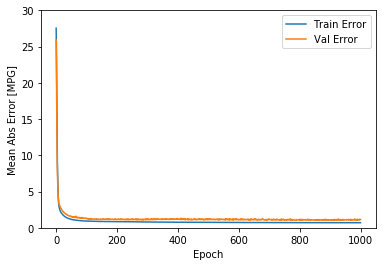

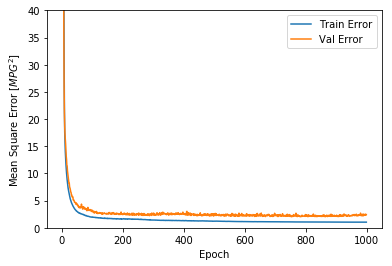

In [16]:
plot_history(history_object_B)

In [17]:
# Range of how wrong we allow a prediction to be, random number for now. unsure what is considered "good"
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print((numCorrect / float(numExamples))*100,"%")

epsilon = 1
test_predictions_B = model_B.predict(normed_test).flatten()
errorVec = test_predictions_B - test_labels
accuracy(errorVec, epsilon)



73.73965387509406 %
